In [52]:
#Import Modules
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.helpers import write_geotiff

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import BandIndices

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
#define area of interest
query = {
    
        #Mathoura Large
'y': (-35.6545, -36.0320),
'x': (144.8179, 145.4289), 
    
    
            #Moria Lakes
# 'y': (-35.9634, -35.8515),
# 'x': (144.8887, 145.0738),
    
                #lake Frome
# 'y': (-30.354, -30.889),
# 'x': (139.482, 140.032),

        #lake carnegie
# 'y': (-36.900, -36.988),
# 'x': (149.800, 149.925),

            #lake carnegie Smol
'y': (-26.076, -26.352),
'x': (122.216, 122.552),
    
    
'time': ('2016-01-01', '2016-12-31'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [54]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8.isel(time=0)

<xarray.Dataset>
Dimensions:          (x: 1418, y: 1335)
Coordinates:
    time             datetime64[ns] 2016-01-11T01:45:23.500000
  * y                (y) float64 -2.858e+06 -2.858e+06 ... -2.891e+06 -2.891e+06
  * x                (x) float64 -9.662e+05 -9.662e+05 ... -9.308e+05 -9.308e+05
Data variables:
    coastal_aerosol  (y, x) int16 533 529 529 536 532 ... 572 578 571 574 570
    blue             (y, x) int16 517 520 517 515 513 ... 566 576 572 569 569
    green            (y, x) int16 842 842 859 880 885 ... 914 939 943 942 928
    red              (y, x) int16 1591 1618 1736 1771 ... 1769 1795 1785 1753
    nir              (y, x) int16 2400 2487 2562 2561 ... 2269 2321 2350 2306
    swir1            (y, x) int16 3431 3565 3620 3648 ... 3607 3675 3666 3619
    swir2            (y, x) int16 3079 3183 3205 3302 ... 2797 2866 2908 2858
Attributes:
    crs:      EPSG: 3577

In [55]:
#define number of total observations

total_obs = int(len(data_lst8.time))
total_obs

23

In [56]:
#turn terrain masked values form -999 to Nan

want_to_mask = (data_lst8 == -999).to_array(dim='variables').all(dim='variables')
terrain_out = data_lst8.where(~want_to_mask, np.NaN)

In [57]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 23, x: 1418, y: 1335)
Coordinates:
  * time          (time) datetime64[ns] 2016-01-11T01:45:23.500000 ... 2016-12-28T01:45:33
  * y             (y) float64 -2.858e+06 -2.858e+06 ... -2.891e+06 -2.891e+06
  * x             (x) float64 -9.662e+05 -9.662e+05 ... -9.308e+05 -9.308e+05
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 16383 ... 16383 16383 16383
Attributes:
    crs:      EPSG: 3577

In [58]:
# #load wofs filtered summary
wofs_filtered_summary= dc.load(product = 'wofs_annual_summary', **query)
wofs_filtered_summary

<xarray.Dataset>
Dimensions:      (time: 1, x: 1418, y: 1335)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01
  * y            (y) float64 -2.858e+06 -2.858e+06 ... -2.891e+06 -2.891e+06
  * x            (x) float64 -9.662e+05 -9.662e+05 ... -9.308e+05 -9.308e+05
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 27 27 26 26 26 26 26 ... 34 34 34 34 34 35
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:      EPSG: 3577

In [59]:
#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality

<xarray.DataArray 'pixelquality' (time: 23, y: 1335, x: 1418)>
array([[[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [False, False, ...,  True,  True],
        [False, False, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       ...,

       [[False, False, ...,  True,  True],
        [False, False, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-11T01:45:23.500000 ... 2016-12-28T01:45:33
  * y        (y) float64 -2.858e+06 -2.858e+06 ... -2.891e+06 -2.891e+06
  * 

In [60]:
#apply Mask
Masked_lst8_data = terrain_out.where(good_quality)

In [82]:
data_lst8_once = Masked_lst8_data.isel(time=3)
data_lst8_once

<xarray.Dataset>
Dimensions:          (x: 1418, y: 1335)
Coordinates:
    time             datetime64[ns] 2016-02-28T01:45:13
  * y                (y) float64 -2.858e+06 -2.858e+06 ... -2.891e+06 -2.891e+06
  * x                (x) float64 -9.662e+05 -9.662e+05 ... -9.308e+05 -9.308e+05
Data variables:
    coastal_aerosol  (y, x) float64 551.0 547.0 549.0 ... 498.0 493.0 495.0
    blue             (y, x) float64 531.0 529.0 538.0 ... 506.0 504.0 498.0
    green            (y, x) float64 891.0 912.0 922.0 ... 873.0 873.0 867.0
    red              (y, x) float64 1.679e+03 1.708e+03 ... 1.667e+03 1.642e+03
    nir              (y, x) float64 2.75e+03 2.735e+03 ... 2.298e+03 2.263e+03
    swir1            (y, x) float64 3.551e+03 3.592e+03 ... 3.504e+03 3.455e+03
    swir2            (y, x) float64 3.123e+03 3.262e+03 ... 2.739e+03 2.698e+03
Attributes:
    crs:      EPSG: 3577

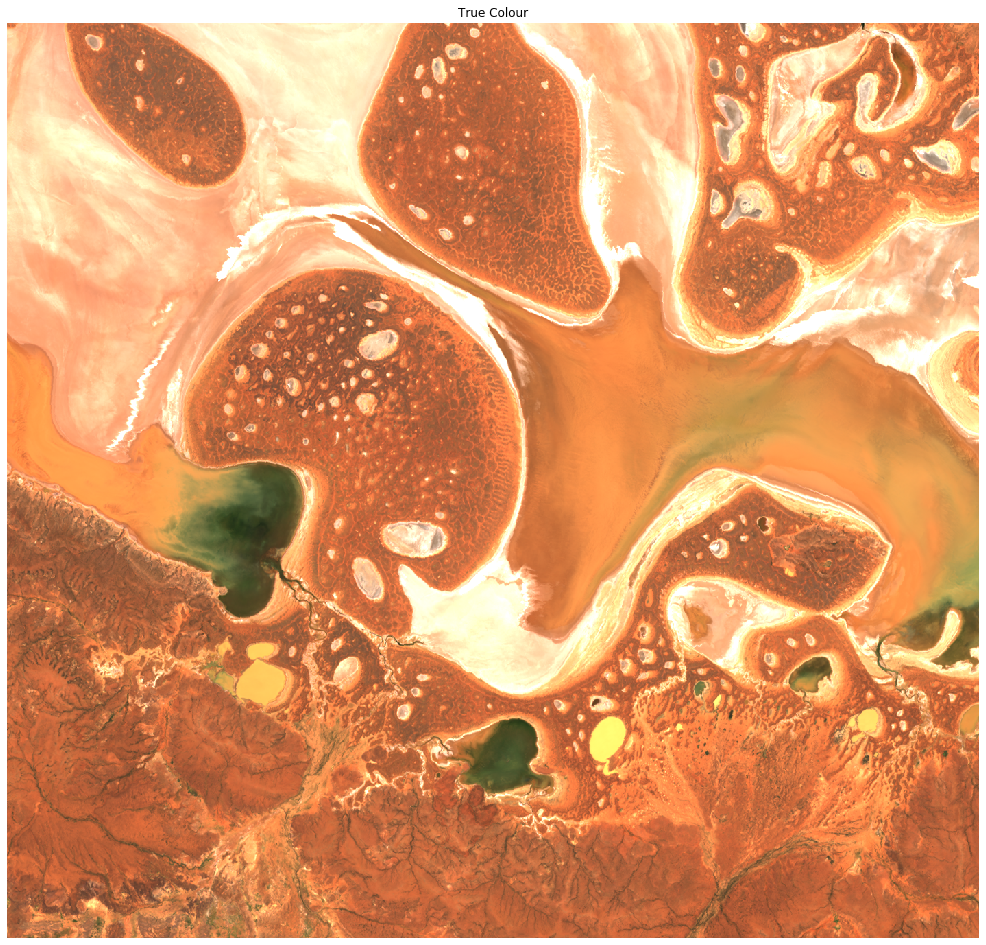

In [83]:


#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [63]:
#Do tassled Cap transformation
TCI = BandIndices.tasseled_cap(Masked_lst8_data, tc_bands=['wetness'], drop=True)

tcw = TCI['wetness']




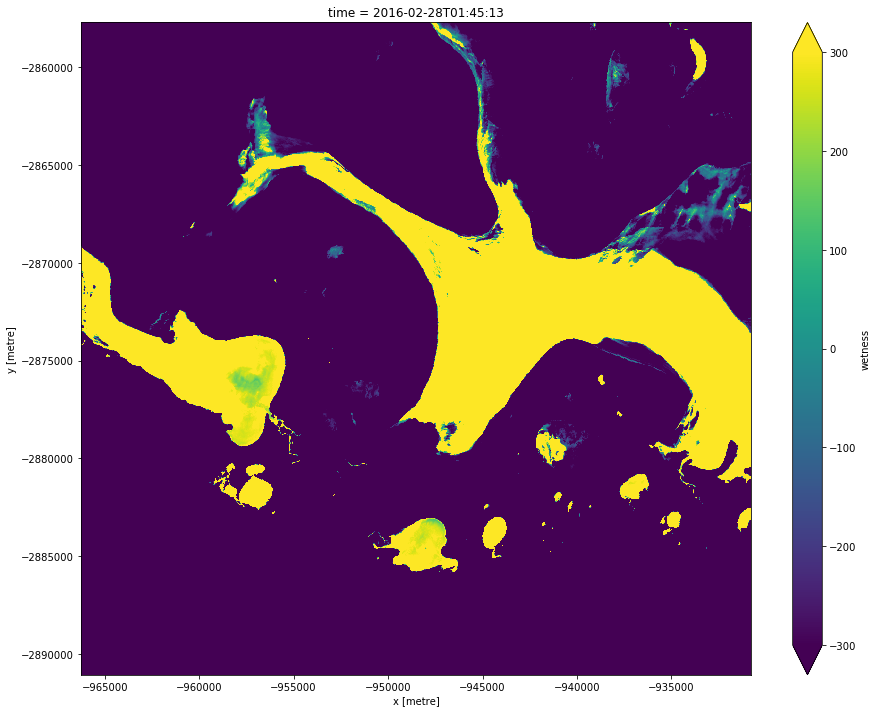

In [89]:
tcw.isel(time=3).plot(cmap='viridis', figsize =(15,12),vmin=-300)

In [65]:
#make Fisher index

lst_fisher = 1.7204 +((171*Masked_lst8_data['green'])+(3*Masked_lst8_data['red'])-(70*Masked_lst8_data['nir'])-(45*Masked_lst8_data['swir1'])-(71*Masked_lst8_data['swir2']))/10000
lst_fisher

<xarray.DataArray (time: 23, y: 1335, x: 1418)>
array([[[-37.5045, -39.4468, ..., -33.29  , -33.2014],
        [-37.1558, -36.7939, ..., -33.8348, -32.8028],
        ...,
        [     nan,      nan, ..., -34.8849, -34.3106],
        [     nan,      nan, ..., -35.2297, -34.6042]],

       [[-41.3669, -42.1797, ..., -16.4824, -15.2073],
        [-40.5848, -41.1434, ..., -18.6321, -17.4676],
        ...,
        [-32.117 , -31.2703, ..., -36.9566, -36.2065],
        [-31.4301, -32.7197, ..., -36.2081, -35.8331]],

       ...,

       [[     nan,      nan, ..., -32.4253, -32.1595],
        [     nan,      nan, ..., -33.0873, -32.8197],
        ...,
        [-32.0803, -31.749 , ..., -34.1502, -34.2103],
        [-30.8419, -31.2381, ..., -33.9259, -33.8161]],

       [[-41.3006, -41.0964, ..., -35.6857, -35.3281],
        [-40.7843, -41.1225, ..., -36.5796, -35.8452],
        ...,
        [-33.3532, -31.1337, ..., -35.9731, -35.341 ],
        [-31.3766, -33.678 , ..., -35.943 , -35.1653]]])

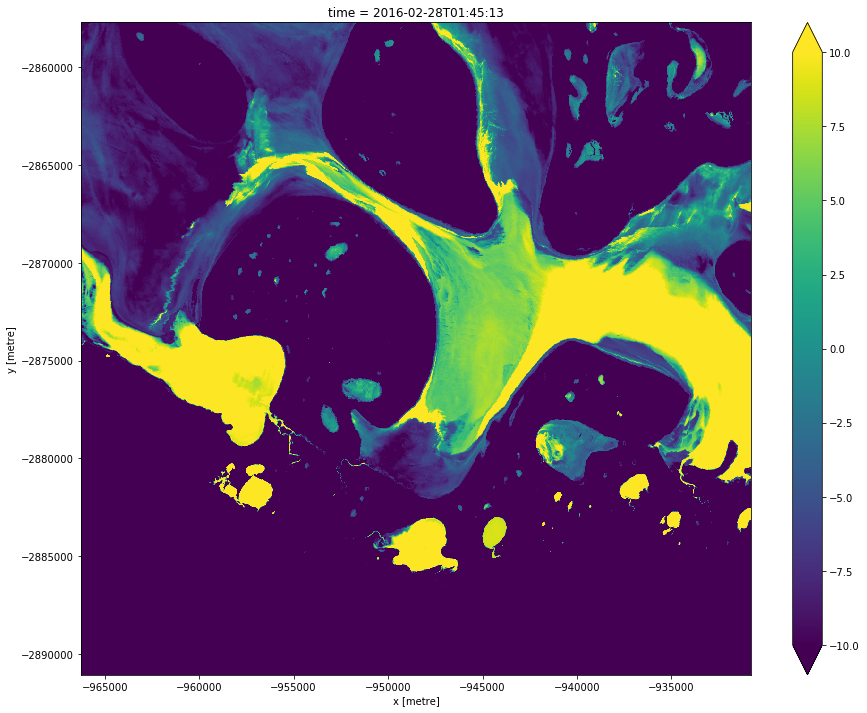

In [86]:
lst_fisher.isel(time=3).plot(cmap='viridis', figsize =(15,12), vmin=-10)

In [67]:
inundated_veg_msk = (np.logical_and(lst_fisher>=-10,tcw>=-400))
inundated_veg = lst_fisher.where(inundated_veg_msk==True,0)
inundated_veg = inundated_veg.where(inundated_veg_msk==False,1)

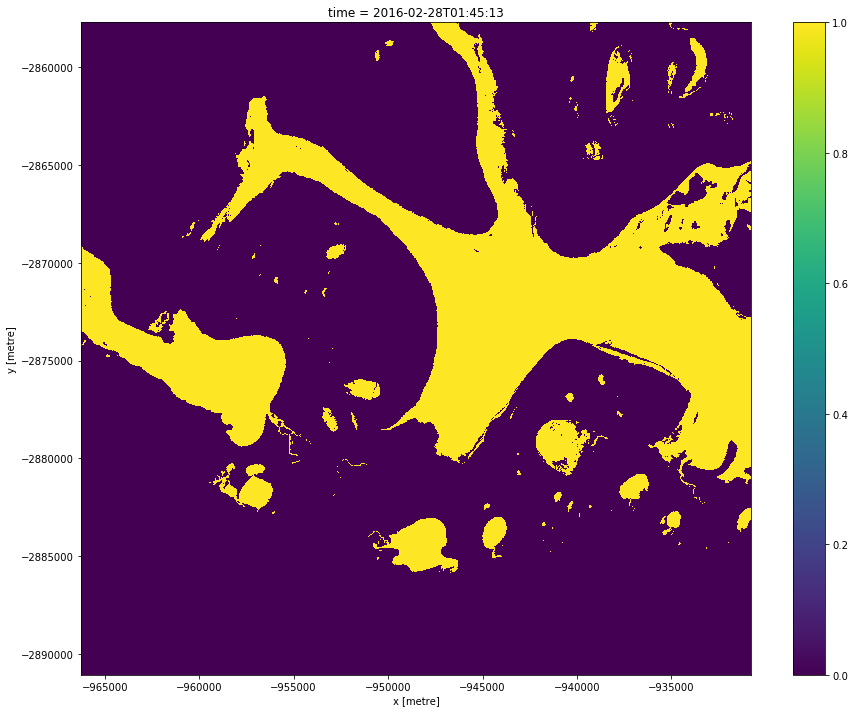

In [87]:
inundated_veg.isel(time=3).plot(cmap='viridis', figsize =(15,12))

In [69]:
# count_wet = inundated_veg.where(inundated_veg==1)
count_wet = inundated_veg.where(inundated_veg>0).count(dim=['x','y'])

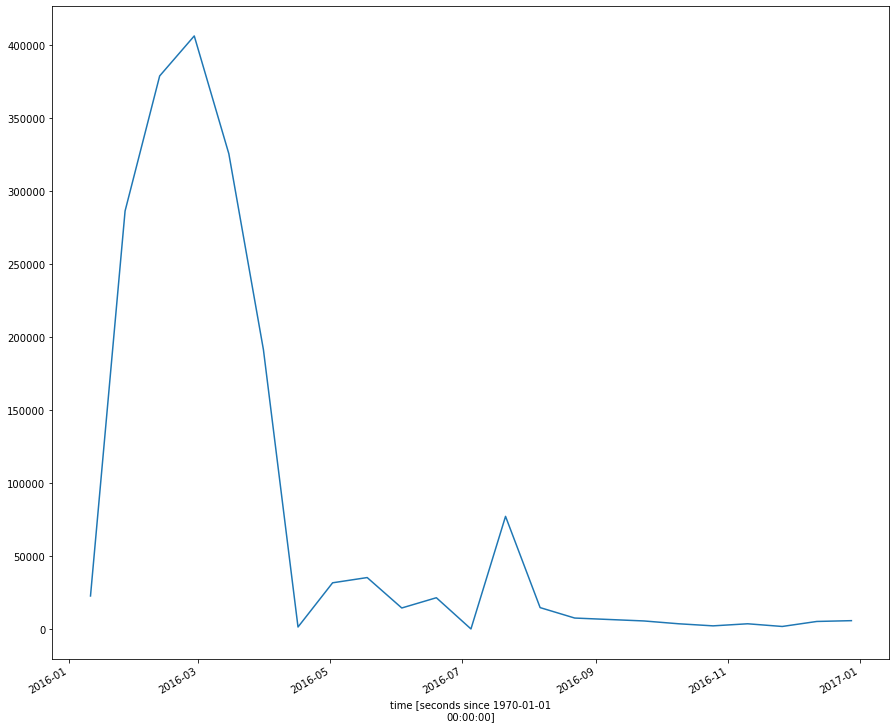

In [70]:
count_wet.plot(figsize =(15,12))

In [71]:
wet_frequency = inundated_veg.sum(dim='time')

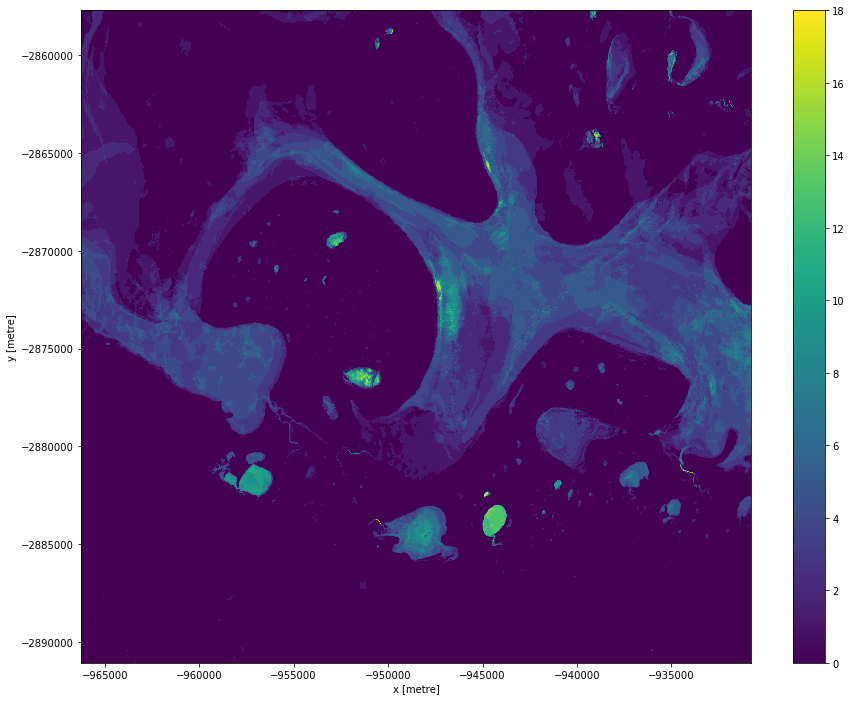

In [72]:
wet_frequency.plot(cmap='viridis', figsize =(15,12))

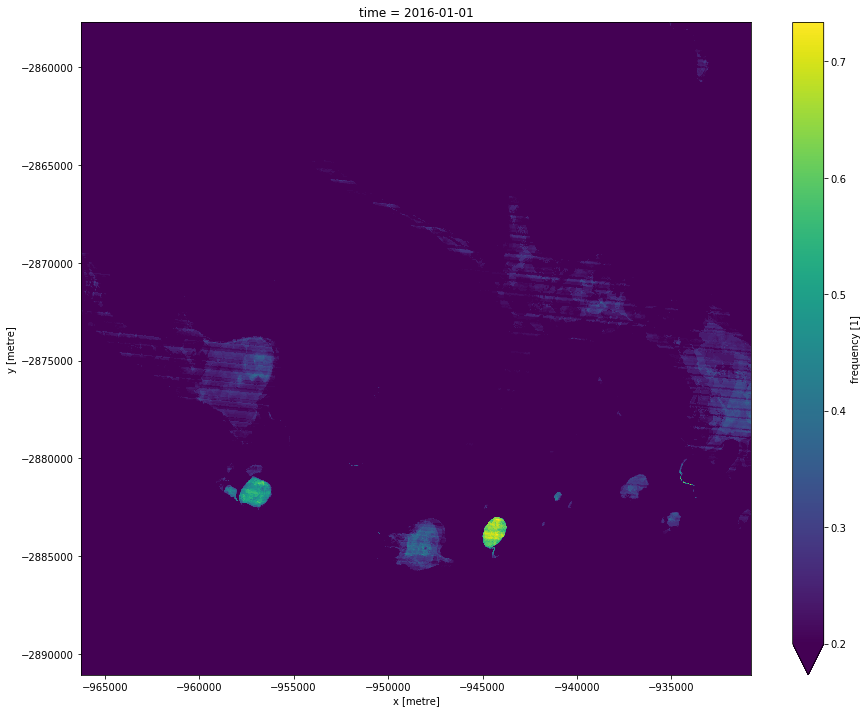

In [73]:
wofs_filtered_summary.frequency.plot(cmap='viridis',figsize =(15,12),vmin=0.2,)

In [74]:
precent_threhold = total_obs*0.2
precent_threhold

4.6000000000000005

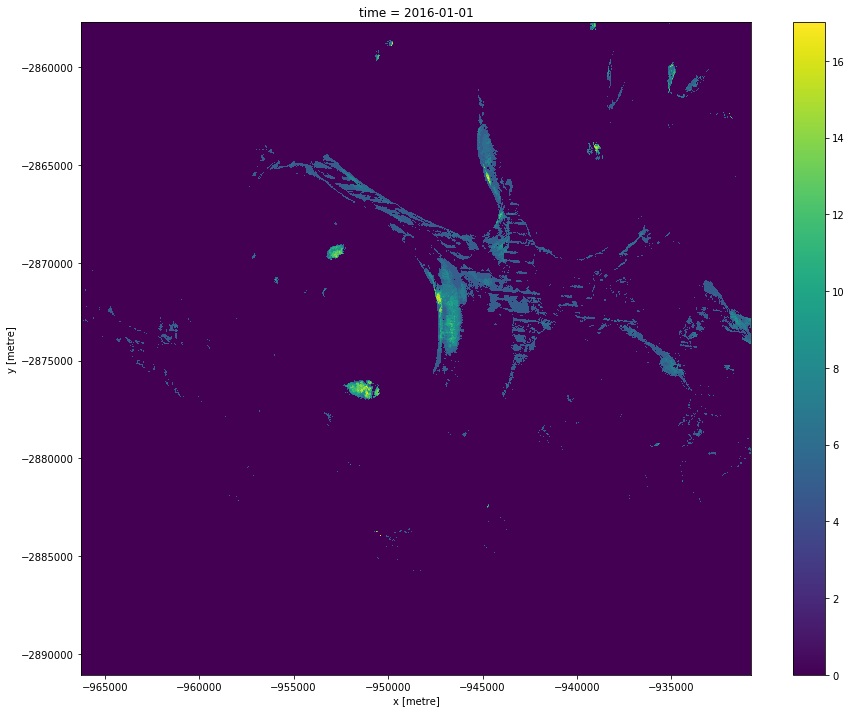

In [75]:
persistant_wet = wet_frequency.where(wet_frequency>precent_threhold,0)
persistant_wet = persistant_wet.where(wofs_filtered_summary.frequency<0.2,0)
persistant_wet.plot(figsize =(15,12))

In [76]:
persistant_wet

<xarray.DataArray (y: 1335, x: 1418, time: 1)>
array([[[0.],
        [0.],
        ...,
        [0.],
        [0.]],

       [[0.],
        [0.],
        ...,
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        ...,
        [0.],
        [0.]],

       [[0.],
        [0.],
        ...,
        [0.],
        [0.]]])
Coordinates:
  * y        (y) float64 -2.858e+06 -2.858e+06 ... -2.891e+06 -2.891e+06
  * x        (x) float64 -9.662e+05 -9.662e+05 ... -9.308e+05 -9.308e+05
  * time     (time) datetime64[ns] 2016-01-01

In [77]:
# Masked_lst8_data

In [78]:
# Data_out = Masked_lst8_data.drop(['coastal_aerosol','nir','swir1','swir2'])
# Data_out['inundated_veg'] = inundated_veg.astype('float64')
# # Data_out

In [79]:
# Data_out_once = Data_out.isel(time=0)
# Data_out_once['persistant_wet']=persistant_wet.astype('float64')
# Data_out_once['WOfS_frequency']=wofs_filtered_summary.frequency.isel(time=0).astype('float64')
# Data_out_once

In [80]:
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
#write_geotiff('/g/data/u46/users/ck9738/Datasets/Tasselled_cap_tifs/Tiletest_-2_-14_2018.tif',Data_out_once)